# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [3]:
import numpy as np
import awkward as ak

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture

from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.plotting import plot_sim_reco, plot_tracksters, plot_dendrogram
from reco.energy import get_total_energy
from reco.data import get_bary_data, get_lc_data, get_event_data, clusters_by_indices

from reco.evaluation import evaluate, evaluate_remapped, baseline_evaluation

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_1.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [4]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

### Extract the event data and evaluate

In [ ]:
eid = 1

t_indexes = trackster_data["vertices_indexes"][eid]
t_multiplicity = trackster_data["vertices_multiplicity"][eid]

# simulation
st_indexes = simtrackster_data["stsSC_vertices_indexes"][eid]
st_multiplicity = simtrackster_data["stsSC_vertices_multiplicity"][eid]

t_x, t_y, t_z, t_energy = clusters_by_indices(cluster_data, t_indexes, eid)
st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indexes, eid)

nhits = cluster_data["cluster_number_of_hits"][eid]

Tracksters reco: 3065, tracksters sim: 1
Simulated energy: 311.29 GeV, reconstructed energy: 14601.58 GeV (4690.69%)


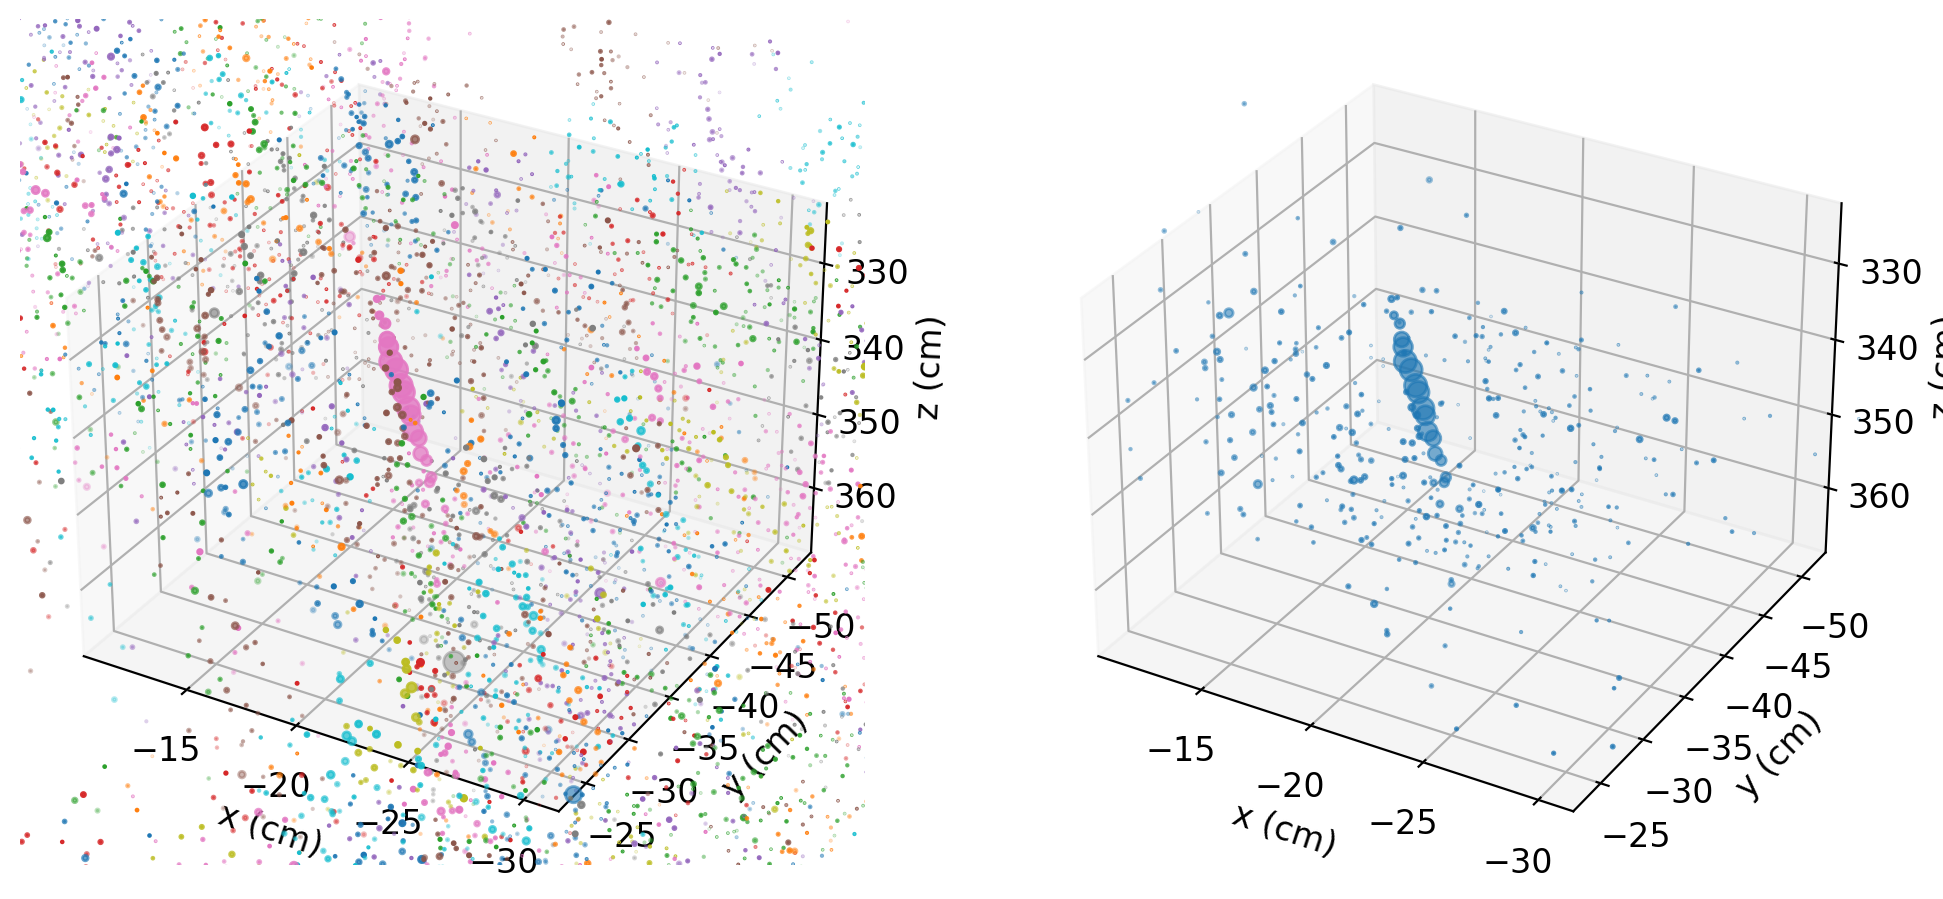

In [44]:
print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, t_multiplicity)
sim_total = get_total_energy(st_energy, st_multiplicity)
print(f"Simulated energy: {sim_total:.2f} GeV, reconstructed energy: {reco_total:.2f} GeV ({(reco_total / sim_total) * 100:.2f}%)")

ax1, ax2 = plot_sim_reco(
    t_x,
    t_y,
    t_z,
    t_energy,
    st_x,
    st_y,
    st_z,
    st_energy, 
    st_indexes,
    st_multiplicity,
)

In [45]:
precision, recall, fscore = evaluate(
    nhits,
    t_indexes,
    st_indexes,
    t_energy,
    st_energy,
    t_multiplicity,
    st_multiplicity
)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.00, Recall: 0.10, F-score: 0.02


### k-means

Apply k-means algorithm on CLUE3D barycentres

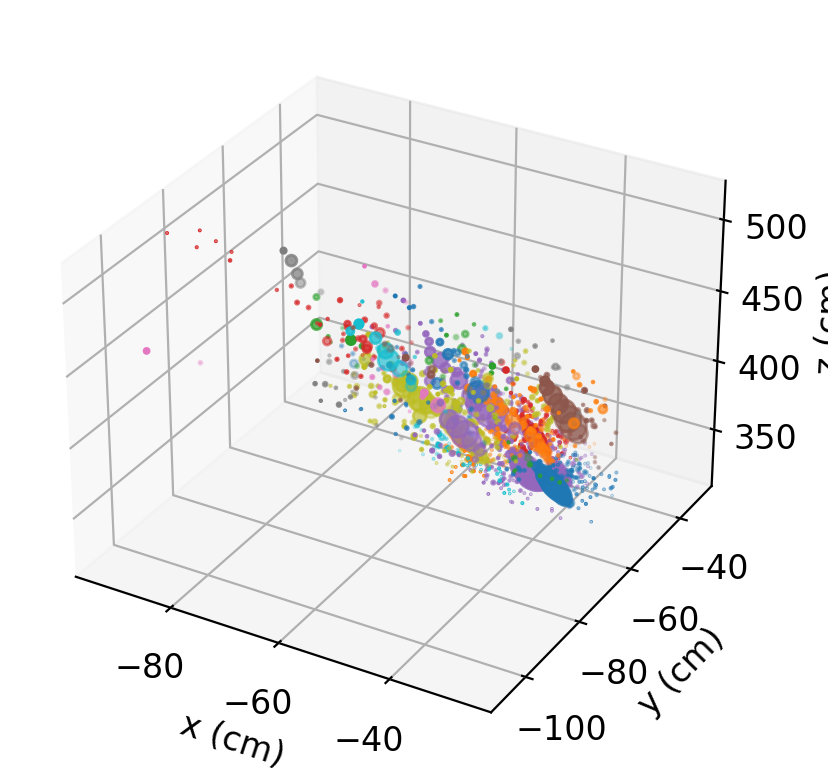

In [29]:
# kmeans on barycentres
def kmeans_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary, sample_weight=raw_e)
    return kmeans.labels_

labels = kmeans_bary(trackster_data, eid)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

In [31]:
precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"Reco tracksters: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Reco tracksters: 29 Precision: 0.75, Recall: 0.20, F-score: 0.24


In [32]:
### Running it on layerclusters - for comparison

Precision: 0.74, Recall: 0.11, F-score: 0.14


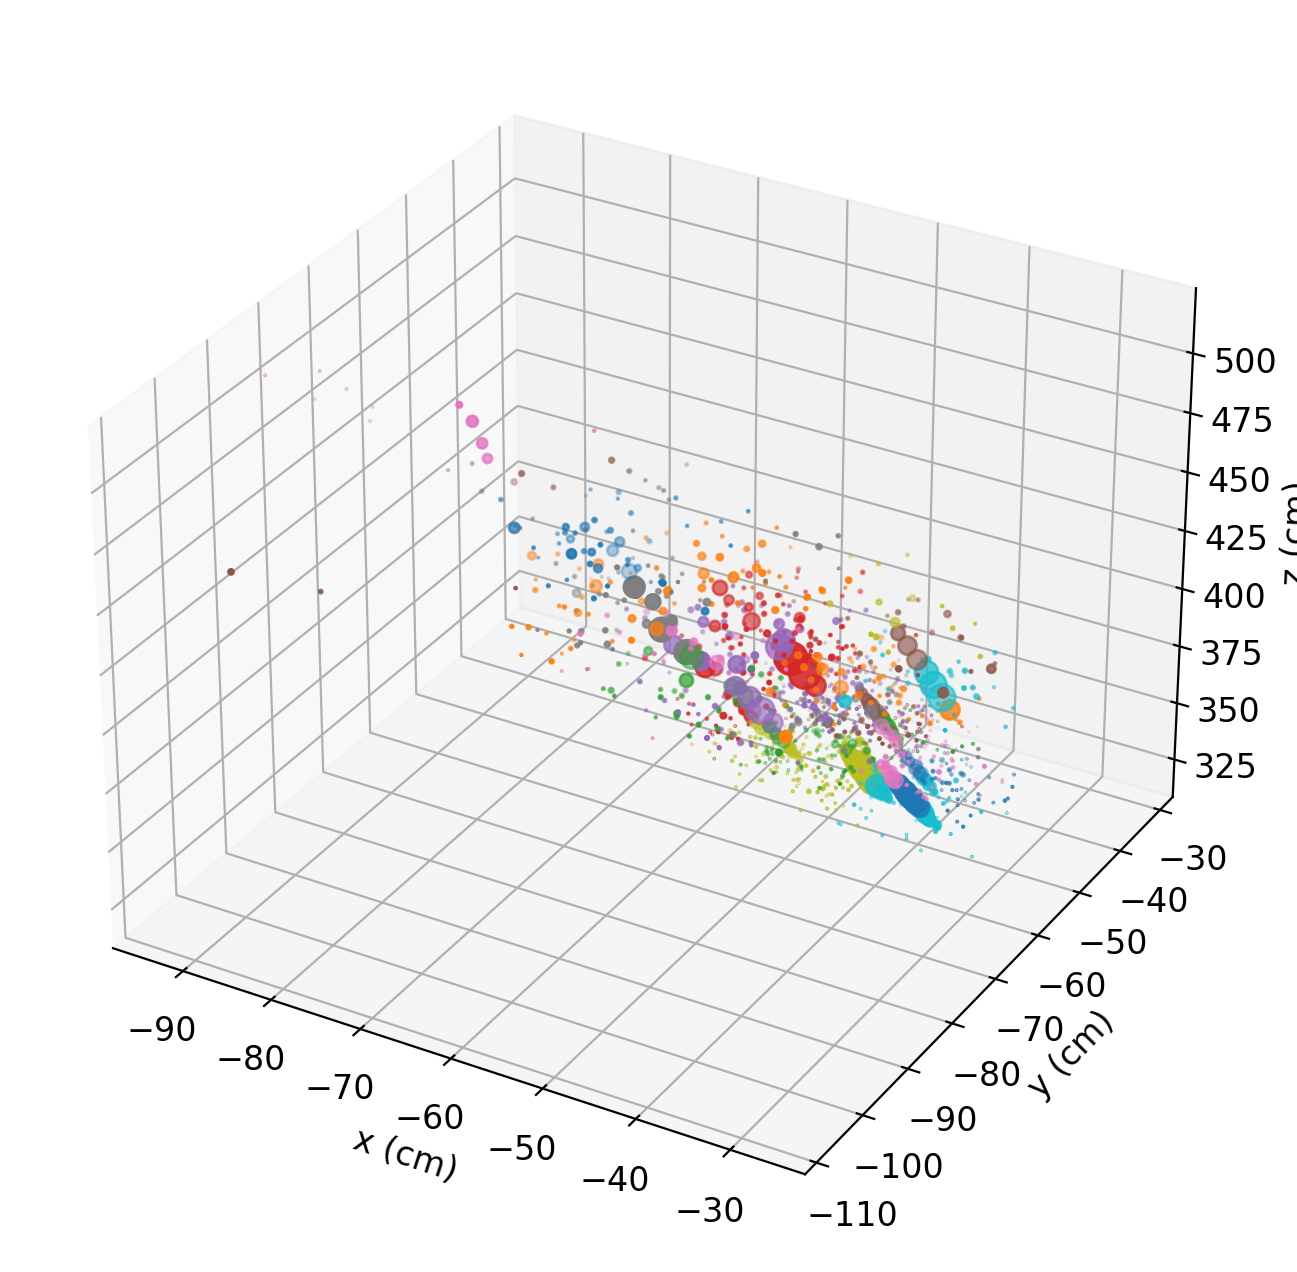

In [33]:
# kmeans on layerclusters (for comparison)
K = sum(trackster_data["raw_energy"][eid] > 10)

X_vertices = get_lc_data(cluster_data, trackster_data, eid)
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
rm = remap_items_by_label(ak.flatten(t_multiplicity), kmeans.labels_)

precision, recall, fscore = evaluate(nhits, ri, st_indexes, re, st_energy, rm, st_multiplicity)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")


rx = remap_items_by_label(ak.flatten(t_x), kmeans.labels_)
ry = remap_items_by_label(ak.flatten(t_y), kmeans.labels_)
rz = remap_items_by_label(ak.flatten(t_z), kmeans.labels_)
re = remap_items_by_label(ak.flatten(t_energy), kmeans.labels_)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

### GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

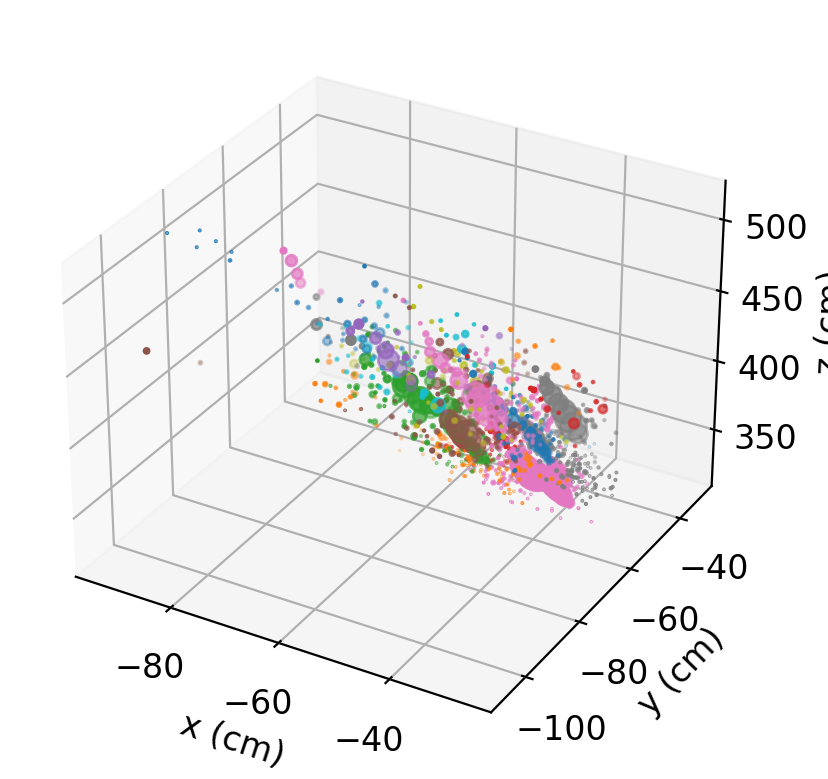

In [34]:
# kmeans on barycentres

def gmm_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)
    return gmm.predict(X_bary)

gmm_labels = gmm_bary(trackster_data, eid)
r_indexes = remap_arrays_by_label(t_indexes, gmm_labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

In [35]:
precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, gmm_labels)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.66, Recall: 0.19, F-score: 0.22


### DBSCAN

In [ ]:
def dbscan_bary(tracksters, _eid, eps=20):
    X_bary = get_bary(tracksters, _eid)
    raw_e = sample_weight=tracksters["raw_energy"].array()[_eid]
    dbscan = DBSCAN(eps=eps, min_samples=1).fit(X_bary, sample_weight=raw_e)
    return dbscan.labels_

labels = dbscan_bary(tracksters, eid)
plot_remapped(tracksters, eid, labels)

print("Tracksters:", max(labels)+1)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

### Meanshift

In [ ]:
# meanshift on barycentres

def meanshift_bary(tracksters, _eid, bandwidth=25):
    X_bary = get_bary(tracksters, _eid)
    mshift = MeanShift(bandwidth=bandwidth).fit(X_bary)
    return mshift.labels_

labels = meanshift_bary(tracksters, eid)

plot_remapped(tracksters, eid, labels)
print("Tracksters:", max(labels)+1)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

### Agglomerative

In [46]:
def agglomerative_bary(tracksters, _eid, distance_threshold=0):
    X_bary = get_bary(tracksters, _eid)
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(X_bary) 
    return model.labels_

plot_dendrogram(model, truncate_mode="level", p=3)

## Evaluations

In [36]:
# TODO: rework this to support the data based stuff
baseline_evaluation(gmm_bary, cluster_data, trackster_data, simtrackster_data, eng_t=10)

E0: nTIn: 71	nTSim: 10	nTReco: 14	P: 0.65 R: 0.15 F:0.18
E1: nTIn: 132	nTSim: 10	nTReco: 29	P: 0.73 R: 0.20 F:0.23
E2: nTIn: 45	nTSim: 10	nTReco: 13	P: 0.90 R: 0.25 F:0.29
E3: nTIn: 114	nTSim: 10	nTReco: 14	P: 0.62 R: 0.43 F:0.46
E4: nTIn: 93	nTSim: 10	nTReco: 18	P: 0.73 R: 0.30 F:0.34
E5: nTIn: 71	nTSim: 10	nTReco: 13	P: 0.76 R: 0.19 F:0.22
E6: nTIn: 65	nTSim: 10	nTReco: 11	P: 0.74 R: 0.48 F:0.52
E7: nTIn: 42	nTSim: 10	nTReco: 10	P: 0.70 R: 0.30 F:0.33
E8: nTIn: 74	nTSim: 10	nTReco: 12	P: 0.75 R: 0.28 F:0.32
E9: nTIn: 94	nTSim: 10	nTReco: 12	P: 0.60 R: 0.33 F:0.36
E10: nTIn: 100	nTSim: 10	nTReco: 15	P: 0.71 R: 0.30 F:0.34
E11: nTIn: 126	nTSim: 10	nTReco: 16	P: 0.66 R: 0.32 F:0.36
E12: nTIn: 91	nTSim: 10	nTReco: 18	P: 0.60 R: 0.30 F:0.33
E13: nTIn: 131	nTSim: 10	nTReco: 23	P: 0.71 R: 0.13 F:0.15
E14: nTIn: 116	nTSim: 10	nTReco: 18	P: 0.58 R: 0.22 F:0.25
E15: nTIn: 124	nTSim: 10	nTReco: 20	P: 0.67 R: 0.25 F:0.28
E16: nTIn: 82	nTSim: 10	nTReco: 13	P: 0.61 R: 0.21 F:0.24
E17: nTIn: 143	nT

KeyboardInterrupt: 